# Animating Other Body Models With AMASS
In the basic [visualization notebook](01-AMASS_Visualization.ipynb), we presented the code snippets to visualize AMASS bodies.
There, we used the original body model for AMASS, i.e. [SMPL+H](http://mano.is.tue.mpg.de/).
However, we can use AMASS to also animate other models namely:
- Body only [SMPL](https://smpl.is.tue.mpg.de/)
- Hand only [MANO](http://mano.is.tue.mpg.de/)
- Holistic Body, Hand and Face model [SMPL-X](https://smpl-x.is.tue.mpg.de/).

In [1]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
from ipywidgets import interact_manual
from ipywidgets import IntSlider


import torch
import numpy as np

from human_body_prior.tools.omni_tools import copy2cpu as c2c
from os import path as osp

support_dir = '../support_data/'

In [3]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
amass_npz_fname = osp.join(support_dir, 'github_data/amass_sample.npz') # the path to body data
bdata = np.load(amass_npz_fname)

num_betas = 16 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

# you can set the gender manually and if it differs from data's then contact or interpenetration issues might happen
subject_gender = bdata['gender']

print('Data keys available:%s'%list(bdata.keys()))

print('The subject of the mocap sequence is  {}.'.format(subject_gender))

Data keys available:['poses', 'gender', 'mocap_framerate', 'betas', 'marker_data', 'dmpls', 'marker_labels', 'trans']
The subject of the mocap sequence is  male.


In [5]:
time_length = len(bdata['trans'])

body_parms = {
    'root_orient': torch.Tensor(bdata['poses'][:, :3]).to(comp_device), # controls the global root orientation
    'pose_body': torch.Tensor(bdata['poses'][:, 3:66]).to(comp_device), # controls the body
    'pose_hand': torch.Tensor(bdata['poses'][:, 66:]).to(comp_device), # controls the finger articulation
    'trans': torch.Tensor(bdata['trans']).to(comp_device), # controls the global body position
    'betas': torch.Tensor(np.repeat(bdata['betas'][:num_betas][np.newaxis], repeats=time_length, axis=0)).to(comp_device), # controls the body shape. Body shape is static
    'dmpls': torch.Tensor(bdata['dmpls'][:, :num_dmpls]).to(comp_device) # controls soft tissue dynamics
}

print('Body parameter vector shapes: \n{}'.format(' \n'.join(['{}: {}'.format(k,v.shape) for k,v in body_parms.items()])))
print('time_length = {}'.format(time_length))

Body parameter vector shapes: 
root_orient: torch.Size([601, 3]) 
pose_body: torch.Size([601, 63]) 
pose_hand: torch.Size([601, 90]) 
trans: torch.Size([601, 3]) 
betas: torch.Size([601, 16]) 
dmpls: torch.Size([601, 8])
time_length = 601


In [6]:
import trimesh
from body_visualizer.tools.vis_tools import colors
from body_visualizer.mesh.mesh_viewer import MeshViewer
from amass.tools.notebook_tools import show_image

imw, imh = 1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

## SMPL-X

First download the [SMPL-X](https://smpl-x.is.tue.mpg.de) body model and extract it to your desired location. The PCA shape space of SMPLX and SMPL+H do not correspond so we cannot change the shape. e.g. betas, nor the dynamics of the body, e.g. DMPLs. However,  We can still pose the model with the data coming from AMASS.
Moreover, SMPL-X has more joints than the SMPLH model because of the eyes and jaw joints, which we wont be able to animate using AMASS.

In [7]:
from human_body_prior.body_model.body_model import BodyModel

bm_smplx_path = osp.join(support_dir, 'body_models/smplx/{}/model.npz'.format(subject_gender))

bm = BodyModel(bm_path=bm_smplx_path, num_betas=num_betas).to(comp_device)

faces = c2c(bm.f)
num_verts = bm.init_v_template.shape[1]

loaded model_type: smplx 


{'pose_body': torch.Size([601, 63]), 'pose_hand': torch.Size([601, 90]), 'betas': torch.Size([601, 16])}


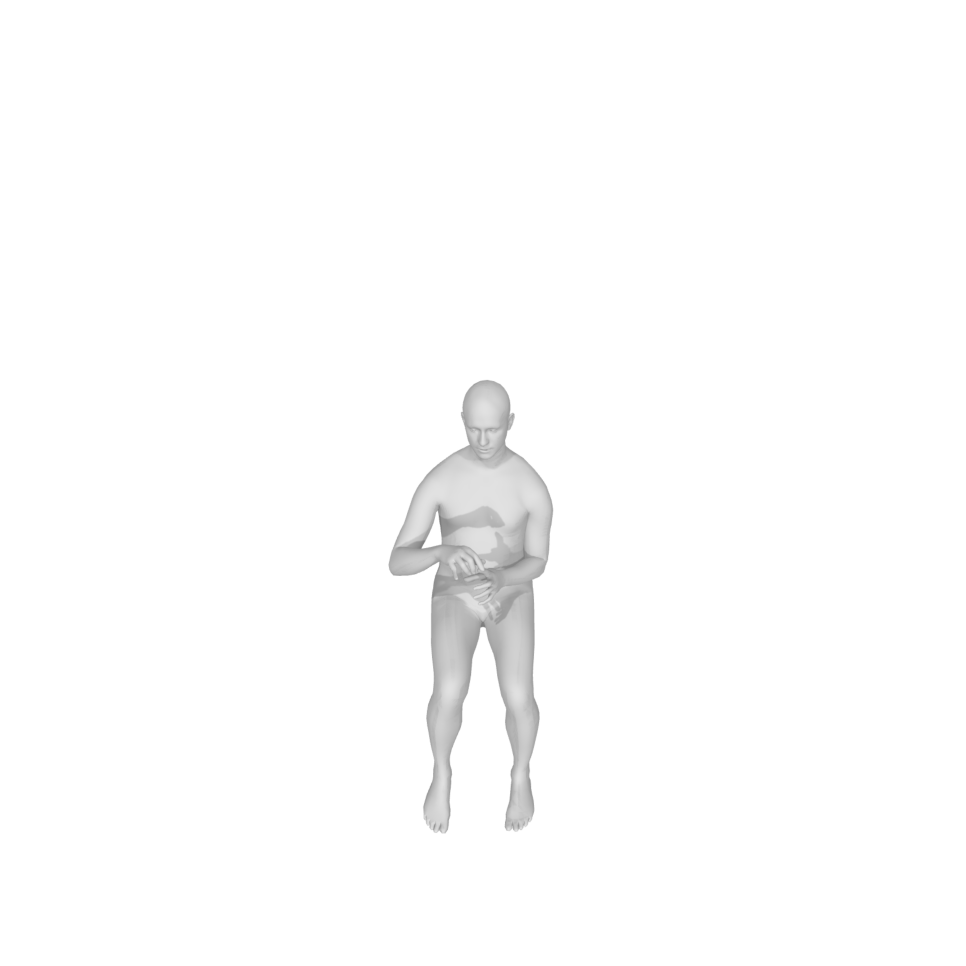

In [8]:
print({k:v.shape for k,v in body_parms.items() if k in ['pose_body', 'pose_hand', 'betas']})
body = bm(**{k:v.to(comp_device) for k,v in body_parms.items() if k in ['pose_body', 'pose_hand']})
body_mesh_wfingers = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (num_verts, 1)))
mv.set_static_meshes([body_mesh_wfingers])
body_image_wfingers = mv.render(render_wireframe=False)
show_image(body_image_wfingers)

You won't see a perfect match with original SMPL+H body because the shape is not taken into account with the above body.
SMPL+H and SMPLx body parameters are not fully compatible.
For next releases of AMASS we intend to include more model types from SMPL family.